In [22]:
import pandas as pd
import os
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shutil
from osgeo import ogr
from collections import OrderedDict
from shapely.geometry import box # type: ignore

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, delete_items
from scripts.utils.cal_crai_calculations import calculate_equal_weighted_index, add_census_tracts
from scripts.utils.cal_crai_plotting import index_plot, plot_region_domain, modular_plot

In [3]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/calcrai_score.csv'
output_folder = 'cal_crai_data'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/calcrai_score.csv.


In [4]:
cal_crai_data = pd.read_csv('../index_method/cal_crai_data/calcrai_score.csv')

In [6]:
# Ensure all values in GEOID are strings
cal_crai_data['GEOID'] = cal_crai_data['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
cal_crai_data['GEOID'] = cal_crai_data['GEOID'].str.zfill(cal_crai_data['GEOID'].str.len().max() + 1)

# Display the dataframe
cal_crai_data

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score,built_environment_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_environment_tract_adjusted,hazard_score,community_capacity,calcrai_score
0,06001400100,0.384966,0.605062,0.589375,0.833488,0.642475,0.582181,0.748805,0.012357,0.113091,-0.058232,0.691840,0.410842,0.593840
1,06001400200,0.384966,0.553534,0.514427,0.841855,0.642475,0.582181,0.748805,-0.116380,0.124264,-0.138434,0.643412,0.334709,0.520210
2,06001400300,0.384966,0.557473,0.450082,0.793298,0.642475,0.582181,0.748805,-0.226903,0.059419,-0.132304,0.701468,0.269558,0.384277
3,06001400400,0.384966,0.549355,0.474044,0.770451,0.642475,0.582181,0.748805,-0.185744,0.028908,-0.144939,0.643200,0.268793,0.417900
4,06001400500,0.384966,0.552923,0.463199,0.744977,0.642475,0.582181,0.748805,-0.204372,-0.005111,-0.139386,0.715325,0.250663,0.350419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.506516,0.468943,0.609509,0.783342,0.642475,0.582181,0.748805,0.046941,0.046124,-0.270099,0.315723,0.416846,1.320288
9125,06115041001,0.455906,0.416459,0.599682,0.742681,0.642475,0.582181,0.748805,0.030061,-0.008179,-0.351789,0.294586,0.305499,1.037047
9126,06115041002,0.541790,0.432561,0.616996,0.766956,0.642475,0.582181,0.748805,0.059802,0.024240,-0.326726,0.305539,0.410306,1.342894
9127,06115041101,0.503268,0.391202,0.668231,0.736324,0.642475,0.582181,0.748805,0.147807,-0.016668,-0.391102,0.278509,0.372438,1.337257


In [7]:
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)

In [79]:
# Merge the passed DataFrame with the census boundary data
merged_df = cal_crai_data.merge(ca_boundaries, on='GEOID')
merged_df['geometry'] = merged_df['geometry']
cal_crai_data_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs=4269)

In [80]:
# Binning into quartiles
binned_equal_df = cal_crai_data_gdf.copy()

# Define the columns to bin
columns_to_bin = [
    'calcrai_score'
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_equal_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_equal_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_equal_df = binned_equal_df[['GEOID','calcrai_score_quartile']]
binned_equal_df

Bin edges for calcrai_score: [0.         0.50782468 0.68969808 1.17630724 1.82769235 4.98642604]


,GEOID,calcrai_score_quartile
0,06001400100,1
1,06001400200,1
2,06001400300,0
3,06001400400,0
4,06001400500,0
...,...,...
9124,06115040902,3
9125,06115041001,2
9126,06115041002,3
9127,06115041101,3


In [81]:
# Create a copy and chain the .replace() calls
binned_df_viz = binned_equal_df.copy()
binned_df_viz['calcrai_score_quartile'] = (
    binned_df_viz['calcrai_score_quartile']
    .replace(0, '0-20%')
    .replace(1, '20-40%')
    .replace(2, '40-60%')
    .replace(3, '60-80%')
    .replace(4, '80+%')
)
binned_df_viz.head()

,GEOID,calcrai_score_quartile
0,06001400100,20-40%
1,06001400200,20-40%
2,06001400300,0-20%
3,06001400400,0-20%
4,06001400500,0-20%


In [82]:
pacific_palisades_vis = binned_df_viz[binned_df_viz['GEOID'].str.startswith('0603727')]
pacific_palisades_cal_crai = cal_crai_data_gdf[cal_crai_data_gdf['GEOID'].str.startswith('0603727')]

In [13]:
keep_columns = ['GEOID', 'geometry', 'hazard_score', 'calcrai_score']
pacific_palisades_columns = pacific_palisades_cal_crai[keep_columns]

In [87]:
merged_df = pd.merge(pacific_palisades_columns, pacific_palisades_vis, on='GEOID', how='left')
merged_df

,GEOID,geometry,hazard_score,calcrai_score,calcrai_score_quartile
0,06037270101,"POLYGON ((-118.40356 34.02911, -118.40348 34.0...",0.367111,2.377858,80+%
1,06037270102,"POLYGON ((-118.40215 34.02768, -118.40104 34.0...",0.367111,2.199993,80+%
2,06037270200,"POLYGON ((-118.39047 34.03101, -118.38845 34.0...",0.550090,1.519182,60-80%
3,06037270300,"POLYGON ((-118.37749 34.03702, -118.37746 34.0...",0.540975,1.506616,60-80%
4,06037271100,"POLYGON ((-118.43742 34.03482, -118.43715 34.0...",0.455882,1.635827,60-80%
...,...,...,...,...,...
57,06037277100,"POLYGON ((-118.38550 33.95993, -118.38542 33.9...",0.498653,1.701349,60-80%
58,06037277200,"POLYGON ((-118.38597 33.94734, -118.38593 33.9...",0.428488,1.793241,60-80%
59,06037277400,"POLYGON ((-118.37868 33.95180, -118.37862 33.9...",0.432844,2.118114,80+%
60,06037278001,"POLYGON ((-118.41874 33.95974, -118.41667 33.9...",0.368272,1.495114,60-80%


In [88]:
merged_df.describe().loc[['count', 'mean', '50%', 'std', 'min', 'max']]

,hazard_score,calcrai_score
count,62.000000,62.000000
mean,0.427223,1.685790
50%,0.427002,1.632421
std,0.052439,0.376284
min,0.362909,0.897091
max,0.574180,2.490486


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


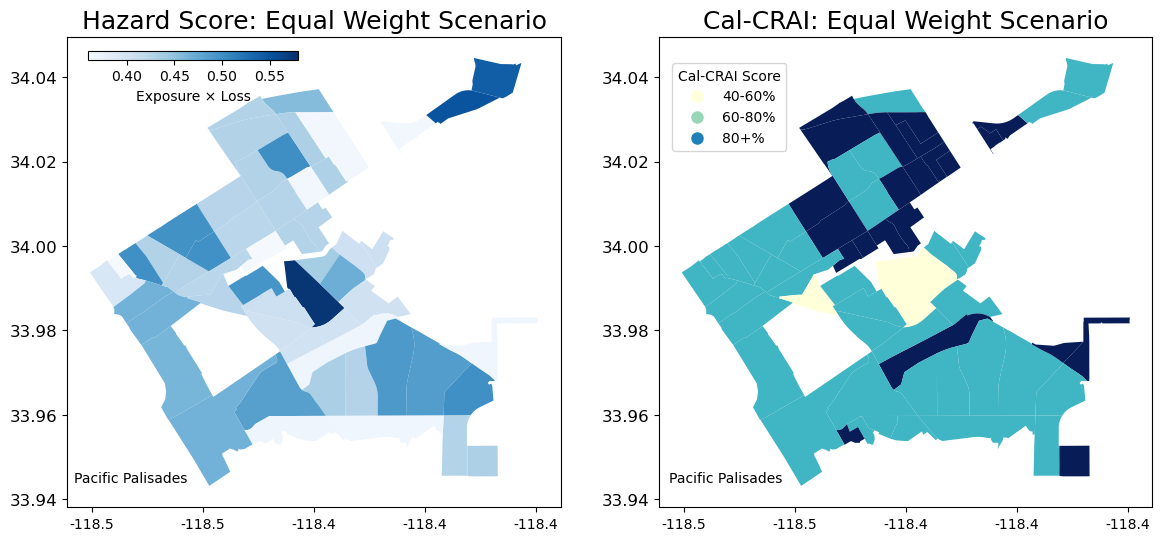

In [86]:
fig = plt.figure(figsize=(14, 18))
gs = plt.GridSpec(1, 2)

# Top-left subplot (hazard score)
ax0 = fig.add_subplot(gs[0, 0])
modular_plot(merged_df, 
             column='hazard_score', 
             plot_title='Hazard Score: Equal Weight Scenario', 
             x_ticks=5, 
             ax=ax0, 
             cmap='Blues', 
             vmin=0.36, 
             vmax=0.58, 
             set_legend=False,
             custom_text='Pacific Palisades',
             custom_text_x=-118.475,
             custom_text_y=33.945,
             font_size=10,
             font_color='black')

cbar_ax = fig.add_axes([0.14, 0.613, 0.15, 0.005])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0.36, vmax=0.58))
sm._A = []  # Required for the ScalarMappable
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(u'Exposure \u00D7 Loss', fontsize=10)

# Top-right subplot (index plot)
ax1 = fig.add_subplot(gs[0, 1])
modular_plot(merged_df, 
             column='calcrai_score_quartile', 
             plot_title='Cal-CRAI: Equal Weight Scenario', 
             ax=ax1, 
             cmap='YlGnBu', 
             categorical=True, 
             set_legend=True, 
             legend_position='center', 
             legend_bbox=(0.2, 0.16), 
             x_ticks=5,
             custom_text='Pacific Palisades',
             custom_text_x=-118.474,
             custom_text_y=33.945,
             font_size=10,
             font_color='black')

# Manually add legend if not automatically generated
handles, labels = ax1.get_legend_handles_labels()
if not labels:  # If no labels detected, add manually
    #unique_values = merged_df['calcrai_score_quartile'].unique()
    unique_values = sorted(merged_df['calcrai_score_quartile'].unique())

    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(val),
                          markerfacecolor=plt.cm.YlGnBu(i/len(unique_values)), markersize=10)
               for i, val in enumerate(unique_values)]
    ax1.legend(handles=handles, title="Cal-CRAI Score", fontsize=10, title_fontsize=10, loc='center', bbox_to_anchor=(0.142, 0.85))
    

In [89]:
drop_geo = merged_df.drop(columns={'geometry'})

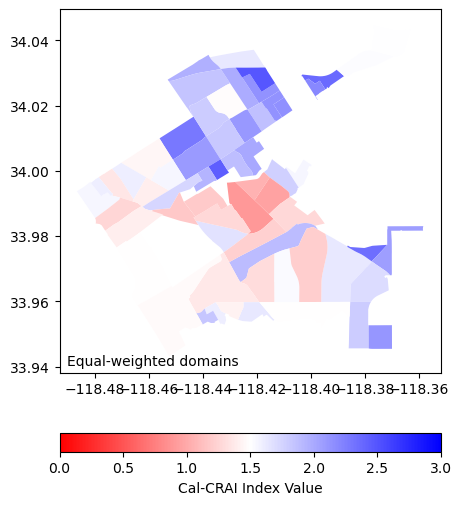

In [90]:
index_plot(drop_geo, column='calcrai_score', vmin=0, vmax=3)

In [52]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/calcrai_wildfire_scenario_index.csv'
output_folder = 'cal_crai_data'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/calcrai_wildfire_scenario_index.csv.


In [53]:
wildfire_cal_crai_data = pd.read_csv('../index_method/cal_crai_data/calcrai_wildfire_scenario_index.csv')

In [54]:
# Ensure all values in GEOID are strings
wildfire_cal_crai_data['GEOID'] = wildfire_cal_crai_data['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
wildfire_cal_crai_data['GEOID'] = wildfire_cal_crai_data['GEOID'].str.zfill(wildfire_cal_crai_data['GEOID'].str.len().max() + 1)

# Display the dataframe
wildfire_cal_crai_data

,GEOID,governance_domain_score,built_environment_domain_score,natural_systems_domain_score,society_economy_domain_score,built_environment_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_environment_tract_adjusted,hazard_score,drought_hazard_score,extreme_heat_hazard_score,inland_flooding_hazard_score,sea_level_rise_hazard_score,wildfire_hazard_score,weighted_community_capacity,wildfire_scenario_calcrai_score
0,06001400100,0.384966,0.605062,0.589375,0.833488,0.642475,0.582181,0.748805,0.012357,0.113091,-0.058232,0.691840,0.878232,0.769035,0.617510,0.167432,0.546436,0.406208,0.743377
1,06001400200,0.384966,0.553534,0.514427,0.841855,0.642475,0.582181,0.748805,-0.116380,0.124264,-0.138434,0.643412,0.878232,0.792429,0.409643,0.172773,0.605283,0.362360,0.598662
2,06001400300,0.384966,0.557473,0.450082,0.793298,0.642475,0.582181,0.748805,-0.226903,0.059419,-0.132304,0.701468,0.852784,0.828517,0.614542,0.161103,0.605283,0.324326,0.535825
3,06001400400,0.384966,0.549355,0.474044,0.770451,0.642475,0.582181,0.748805,-0.185744,0.028908,-0.144939,0.643200,0.852784,0.828517,0.406913,0.167674,0.605283,0.316295,0.522557
4,06001400500,0.384966,0.552923,0.463199,0.744977,0.642475,0.582181,0.748805,-0.204372,-0.005111,-0.139386,0.715325,0.852784,0.828517,0.614532,0.170886,0.605283,0.303488,0.501398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.506516,0.468943,0.609509,0.783342,0.642475,0.582181,0.748805,0.046941,0.046124,-0.270099,0.315723,0.324800,0.382787,0.619160,NaN,0.846492,0.418270,0.494122
9125,06115041001,0.455906,0.416459,0.599682,0.742681,0.642475,0.582181,0.748805,0.030061,-0.008179,-0.351789,0.294586,0.311958,0.374011,0.527876,NaN,0.873744,0.318810,0.364878
9126,06115041002,0.541790,0.432561,0.616996,0.766956,0.642475,0.582181,0.748805,0.059802,0.024240,-0.326726,0.305539,0.322660,0.377173,0.585439,NaN,0.819991,0.413082,0.503764
9127,06115041101,0.503268,0.391202,0.668231,0.736324,0.642475,0.582181,0.748805,0.147807,-0.016668,-0.391102,0.278509,0.353338,0.322773,0.539505,NaN,0.651207,0.355804,0.546376


In [55]:
# Merge the passed DataFrame with the census boundary data
merged_df = wildfire_cal_crai_data.merge(ca_boundaries, on='GEOID')
merged_df['geometry'] = merged_df['geometry']
wildfire_cal_crai_data_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry', crs=4269)

In [93]:
wildfire_cal_crai_data_gdf.columns

Index(['GEOID', 'governance_domain_score', 'built_environment_domain_score',
       'natural_systems_domain_score', 'society_economy_domain_score',
       'built_environment_median', 'natural_systems_median',
       'society_economy_median', 'natural_systems_tract_adjusted',
       'society_economy_tract_adjusted', 'built_environment_tract_adjusted',
       'hazard_score', 'drought_hazard_score', 'extreme_heat_hazard_score',
       'inland_flooding_hazard_score', 'sea_level_rise_hazard_score',
       'wildfire_hazard_score', 'weighted_community_capacity',
       'wildfire_scenario_calcrai_score', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry'],
      dtype='object')

In [94]:
# Binning into quartiles
wildfire_binned = wildfire_cal_crai_data_gdf.copy()

# Define the columns to bin
columns_to_bin = [
    'wildfire_scenario_calcrai_score'
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    wildfire_binned[column + '_quartile'], bin_edges = pd.qcut(
        wildfire_binned[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
wildfire_binned = wildfire_binned[['GEOID','wildfire_scenario_calcrai_score_quartile']]
wildfire_binned

Bin edges for wildfire_scenario_calcrai_score: [0.         0.48792844 0.61544646 0.75255759 2.94198934 8.68127605]


,GEOID,wildfire_scenario_calcrai_score_quartile
0,06001400100,2
1,06001400200,1
2,06001400300,1
3,06001400400,1
4,06001400500,1
...,...,...
9124,06115040902,1
9125,06115041001,0
9126,06115041002,1
9127,06115041101,1


In [99]:
# Create a copy and chain the .replace() calls
binned_df_viz = wildfire_binned.copy()
binned_df_viz['wildfire_scenario_calcrai_score_quartile'] = (
    binned_df_viz['wildfire_scenario_calcrai_score_quartile']
    .replace(0, '0-20%')
    .replace(1, '20-40%')
    .replace(2, '40-60%')
    .replace(3, '60-80%')
    .replace(4, '80+%')
)
binned_df_viz.head()

,GEOID,wildfire_scenario_calcrai_score_quartile
0,06001400100,40-60%
1,06001400200,20-40%
2,06001400300,20-40%
3,06001400400,20-40%
4,06001400500,20-40%


In [100]:
pacific_palisades_wildfire = wildfire_cal_crai_data_gdf[wildfire_cal_crai_data_gdf['GEOID'].str.startswith('0603727')]
pacific_palisades_wildfire_vis = binned_df_viz[binned_df_viz['GEOID'].str.startswith('0603727')]


In [97]:
keep_columns = ['GEOID', 'geometry', 'wildfire_hazard_score', 'wildfire_scenario_calcrai_score']
pacific_palisades_wf_columns = pacific_palisades_wildfire[keep_columns]

In [104]:
palisade_wf_scenario = pd.merge(pacific_palisades_wf_columns, pacific_palisades_wildfire_vis, on='GEOID', how='left')
palisade_wf_scenario

,GEOID,geometry,wildfire_hazard_score,wildfire_scenario_calcrai_score,wildfire_scenario_calcrai_score_quartile
0,06037270101,"POLYGON ((-118.40356 34.02911, -118.40348 34.0...",0.244171,3.517566,80+%
1,06037270102,"POLYGON ((-118.40215 34.02768, -118.40104 34.0...",0.244171,3.193238,80+%
2,06037270200,"POLYGON ((-118.39047 34.03101, -118.38845 34.0...",0.250730,3.217403,80+%
3,06037270300,"POLYGON ((-118.37749 34.03702, -118.37746 34.0...",0.255649,3.183230,80+%
4,06037271100,"POLYGON ((-118.43742 34.03482, -118.43715 34.0...",0.244171,2.990033,80+%
...,...,...,...,...,...
57,06037277100,"POLYGON ((-118.38550 33.95993, -118.38542 33.9...",0.244171,3.507805,80+%
58,06037277200,"POLYGON ((-118.38597 33.94734, -118.38593 33.9...",0.244171,3.204410,80+%
59,06037277400,"POLYGON ((-118.37868 33.95180, -118.37862 33.9...",0.244171,3.718655,80+%
60,06037278001,"POLYGON ((-118.41874 33.95974, -118.41667 33.9...",0.244171,2.777019,60-80%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


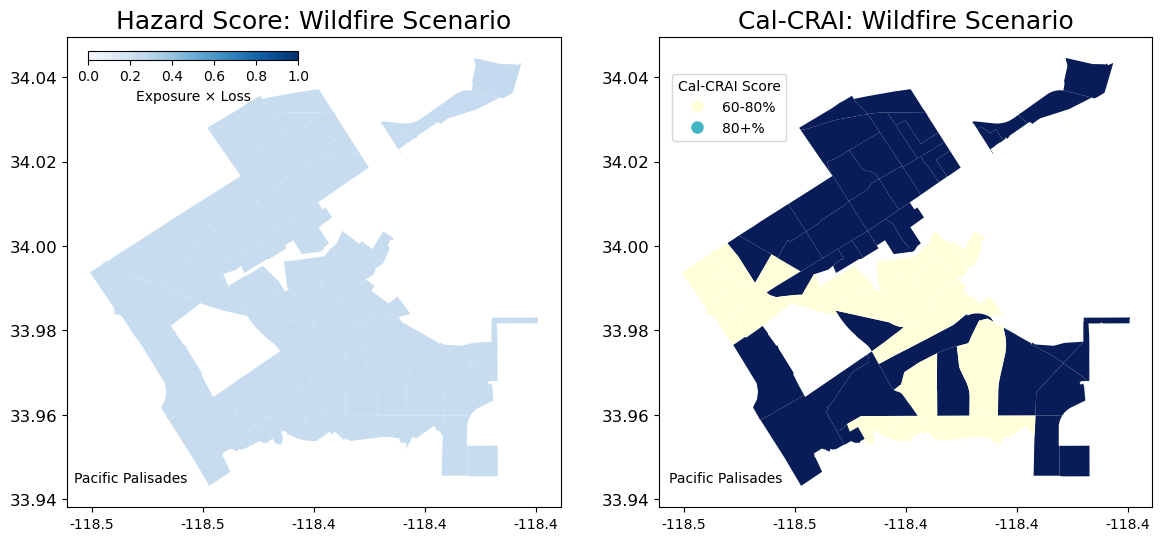

In [105]:
fig = plt.figure(figsize=(14, 18))
gs = plt.GridSpec(1, 2)

# Top-left subplot (hazard score)
ax0 = fig.add_subplot(gs[0, 0])
modular_plot(palisade_wf_scenario, 
             column='wildfire_hazard_score', 
             plot_title='Hazard Score: Wildfire Scenario', 
             x_ticks=5, 
             ax=ax0, 
             cmap='Blues', 
             vmin=0, 
             vmax=1, 
             set_legend=False,
             custom_text='Pacific Palisades',
             custom_text_x=-118.475,
             custom_text_y=33.945,
             font_size=10,
             font_color='black')

cbar_ax = fig.add_axes([0.14, 0.613, 0.15, 0.005])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []  # Required for the ScalarMappable
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(u'Exposure \u00D7 Loss', fontsize=10)

# Top-right subplot (index plot)
ax1 = fig.add_subplot(gs[0, 1])
modular_plot(palisade_wf_scenario, 
             column='wildfire_scenario_calcrai_score_quartile', 
             plot_title='Cal-CRAI: Wildfire Scenario', 
             ax=ax1, 
             cmap='YlGnBu', 
             categorical=True, 
             set_legend=True, 
             legend_position='center', 
             legend_bbox=(0.2, 0.16), 
             x_ticks=5,
             custom_text='Pacific Palisades',
             custom_text_x=-118.474,
             custom_text_y=33.945,
             font_size=10,
             font_color='black')

# Manually add legend if not automatically generated
handles, labels = ax1.get_legend_handles_labels()
if not labels:  # If no labels detected, add manually
    #unique_values = merged_df['calcrai_score_quartile'].unique()
    unique_values = sorted(merged_df['wildfire_scenario_calcrai_score_quartile'].unique())

    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(val),
                          markerfacecolor=plt.cm.YlGnBu(i/len(unique_values)), markersize=10)
               for i, val in enumerate(unique_values)]
    ax1.legend(handles=handles, title="Cal-CRAI Score", fontsize=10, title_fontsize=10, loc='center', bbox_to_anchor=(0.142, 0.85))
    

In [106]:
palisade_wf_scenario.describe().loc[['count', 'mean', '50%', 'std', 'min', 'max']]

,wildfire_hazard_score,wildfire_scenario_calcrai_score
count,62.000000,62.000000
mean,0.244462,3.060272
50%,0.244171,3.080603
std,0.001667,0.289102
min,0.244171,2.483382
max,0.255649,3.760667
